# Given Store Data - Predict Media Cost

I used a lot of notebooks as reference, including the following:

https://www.kaggle.com/code/shashwatraman/eda-adversarial-validation-and-simple-xgboost

https://www.kaggle.com/code/tetsutani/ps3e11-eda-xgb-lgbm-cat-ensemble-lb-0-29267

https://www.kaggle.com/code/ambrosm/pss3e11-zoo-of-models


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm, catboost, xgboost
from lightgbm import LGBMRegressor
from lofo import LOFOImportance, Dataset, plot_importance
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,\
    HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.inspection import PartialDependenceDisplay

# Load the Datasets
I also cleaned up the column names to keep myself sane.

In [3]:
# Load the original and generated data
original = pd.read_csv('./datasets/media_cost/original_train_dataset.csv')
train_df = pd.read_csv('./datasets/media_cost/train.csv', index_col=[0])
test_df = pd.read_csv('./datasets/media_cost/test.csv', index_col=[0])

# Fix the column names
def rename_columns(df):
    df.columns = df.columns.str.replace('(in millions)', '', regex=False)
    df.columns = df.columns.str.replace(' home(approx).1', '_home',
                                        regex=False)
    return df

train_df = rename_columns(train_df)
test_df = rename_columns(test_df)
original = rename_columns(original)

# Create and ID column for the original dataset
original = original.reset_index()
original['id'] = original['index'] + test_df.index[-1] + 1
original = original.drop(columns=['index']).set_index('id')

In [5]:
# Describe the shape of the DataFrames
print(f'The original dataset shape is {original.shape}\n')
print(f'The training dataset shape is {train_df.shape}\n')
print(f'The test dataset shape is {test_df.shape}\n')

The original dataset shape is (51363, 16)

The training dataset shape is (360336, 16)

The test dataset shape is (240224, 15)



In [6]:
# Combine original and training dataset
training_df = pd.concat([train_df, original], axis=0)
del train_df, original

In [7]:
training_df

,store_sales,unit_sales,total_children,num_children_at_home,avg_cars_at_home,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651918,3.70,2.0,4.0,4.0,1.0,10.40,1.0,1.0,18.0,34452.0,1.0,0.0,0.0,0.0,1.0,147.17
651919,10.36,4.0,2.0,0.0,2.0,9.43,0.0,0.0,20.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
651920,11.19,3.0,3.0,0.0,3.0,18.50,0.0,0.0,5.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57


## Adjust Datatypes and Check for Missing Values
Look at the datatypes and check for binary and categorical.

In [8]:
# Check the data types
print(training_df.dtypes)

store_sales             float64
unit_sales              float64
total_children          float64
num_children_at_home    float64
avg_cars_at_home        float64
gross_weight            float64
recyclable_package      float64
low_fat                 float64
units_per_case          float64
store_sqft              float64
coffee_bar              float64
video_store             float64
salad_bar               float64
prepared_food           float64
florist                 float64
cost                    float64
dtype: object


In [9]:
training_df = training_df.astype({
    'unit_sales': 'int32',
    'total_children': 'int32',
    'num_children_at_home': 'int32',
    'avg_cars_at_home': 'int32',
    'recyclable_package': 'int32',
    'low_fat': 'int32',
    'units_per_case': 'int32',
    'store_sqft': 'int32',
    'coffee_bar': 'int32',
    'video_store': 'int32',
    'salad_bar': 'int32',
    'prepared_food': 'int32',
    'florist': 'int32'
})

print(training_df.dtypes)

store_sales             float64
unit_sales                int32
total_children            int32
num_children_at_home      int32
avg_cars_at_home          int32
gross_weight            float64
recyclable_package        int32
low_fat                   int32
units_per_case            int32
store_sqft                int32
coffee_bar                int32
video_store               int32
salad_bar                 int32
prepared_food             int32
florist                   int32
cost                    float64
dtype: object


In [10]:
# Do the same thing for the test dataset
test_df = test_df.astype({
    'unit_sales': 'int32',
    'total_children': 'int32',
    'num_children_at_home': 'int32',
    'avg_cars_at_home': 'int32',
    'recyclable_package': 'int32',
    'low_fat': 'int32',
    'units_per_case': 'int32',
    'store_sqft': 'int32',
    'coffee_bar': 'int32',
    'video_store': 'int32',
    'salad_bar': 'int32',
    'prepared_food': 'int32',
    'florist': 'int32'
})

print(test_df.dtypes)

store_sales             float64
unit_sales                int32
total_children            int32
num_children_at_home      int32
avg_cars_at_home          int32
gross_weight            float64
recyclable_package        int32
low_fat                   int32
units_per_case            int32
store_sqft                int32
coffee_bar                int32
video_store               int32
salad_bar                 int32
prepared_food             int32
florist                   int32
dtype: object


In [11]:
# Check for missing values
print(training_df.isna().sum())

store_sales             0
unit_sales              0
total_children          0
num_children_at_home    0
avg_cars_at_home        0
gross_weight            0
recyclable_package      0
low_fat                 0
units_per_case          0
store_sqft              0
coffee_bar              0
video_store             0
salad_bar               0
prepared_food           0
florist                 0
cost                    0
dtype: int64


# Data Visualization

We do not need to visualize the column id

In [12]:
# Check for unique values in columns
for col in training_df.columns:
    print(training_df[col].nunique(), col)

1049 store_sales
6 unit_sales
6 total_children
6 num_children_at_home
5 avg_cars_at_home
384 gross_weight
2 recyclable_package
2 low_fat
36 units_per_case
20 store_sqft
2 coffee_bar
2 video_store
2 salad_bar
2 prepared_food
2 florist
328 cost


In [13]:
# Break the columns up by their data type
numerical_features = ['store_sales', 'gross_weight', 'units_per_case']

categorical_features = ['unit_sales', 'total_children', 'num_children_at_home',
                        'avg_cars_at_home', 'store_sqft']

binary_features = ['recyclable_package', 'low_fat', 'coffee_bar', 'video_store',
                   'salad_bar', 'prepared_food', 'florist']

all_features = numerical_features + categorical_features + binary_features

print(all_features)

['store_sales', 'gross_weight', 'units_per_case', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'store_sqft', 'recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']


Time to view some data.

In [14]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")

## Histograms

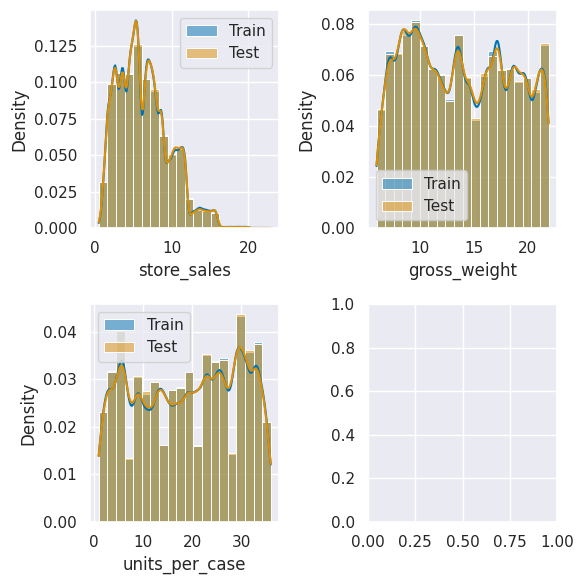

In [15]:
# Numerical Features
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6,6))

for i, var_name in enumerate(numerical_features):
    row = i // ncols
    col = i % ncols

    ax = axes[row, col]
    sns.histplot(training_df[var_name], bins=20, stat="density", kde=True,
                 ax=ax, label='Train')
    sns.histplot(test_df[var_name], bins=20, stat="density", kde=True, ax=ax,
                 label='Test')
    ax.legend()

plt.tight_layout()
plt.show()

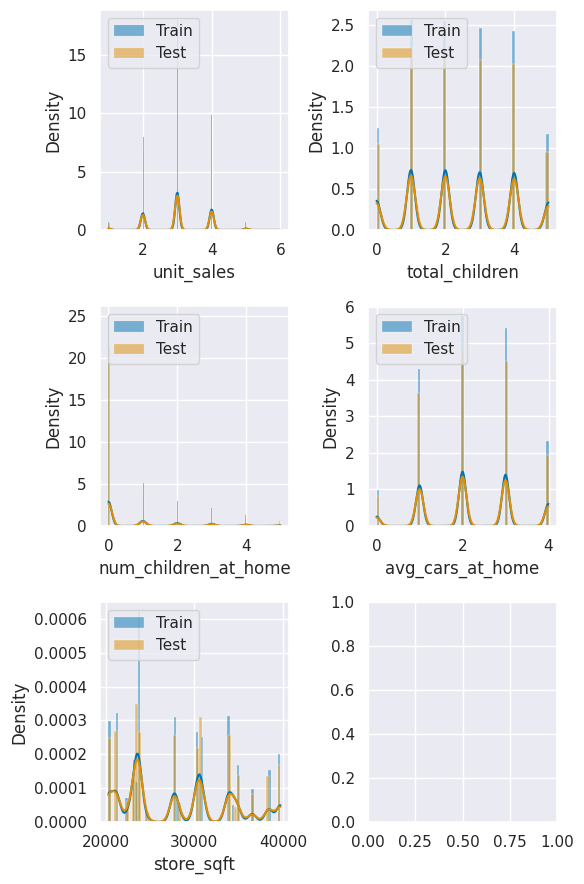

In [16]:
# Categorical data
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))

for i, var_name in enumerate(categorical_features):
    row = i // ncols
    col = i % ncols

    ax = axes[row, col]
    sns.histplot(training_df[var_name], stat="density", kde=True, ax=ax,
                 label='Train')
    sns.histplot(test_df[var_name], stat="density", kde=True, ax=ax,
                 label='Test')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

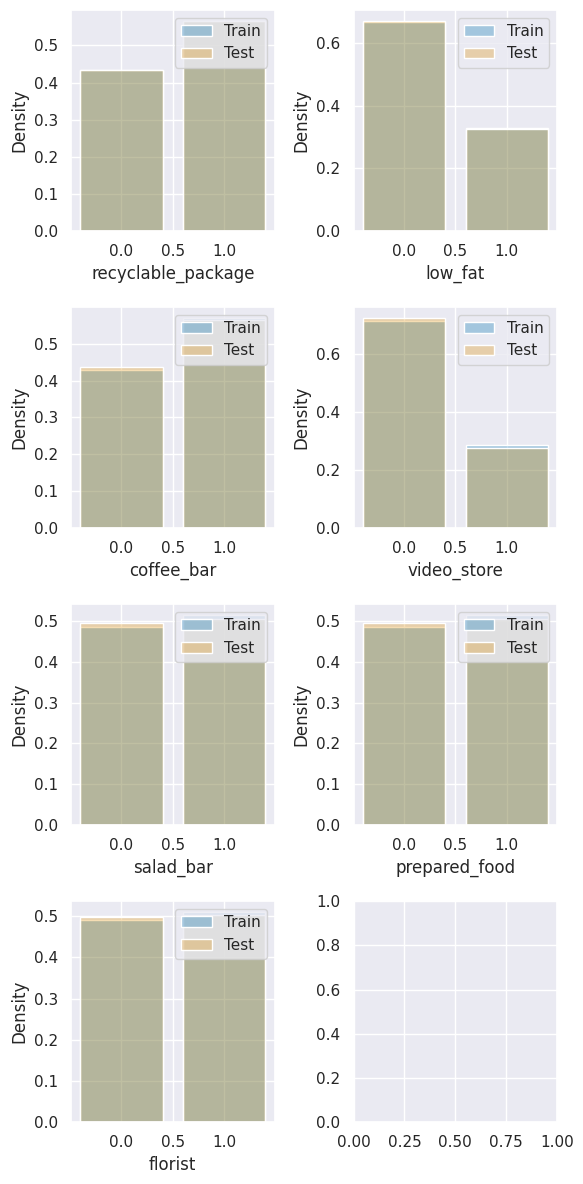

In [17]:
# Binary Data
nrows = 4
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))

for i, var_name in enumerate(binary_features):
    row = i // ncols
    col = i % ncols

    ax = axes[row, col]
    sns.histplot(training_df[var_name], discrete=True, stat="density",
                 alpha=0.3, ax=ax, shrink=0.8, label='Train')
    sns.histplot(test_df[var_name], discrete=True, stat="density", alpha=0.3,
                 ax=ax, shrink=0.8, label='Test')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Correlation Matrix

<Axes: >

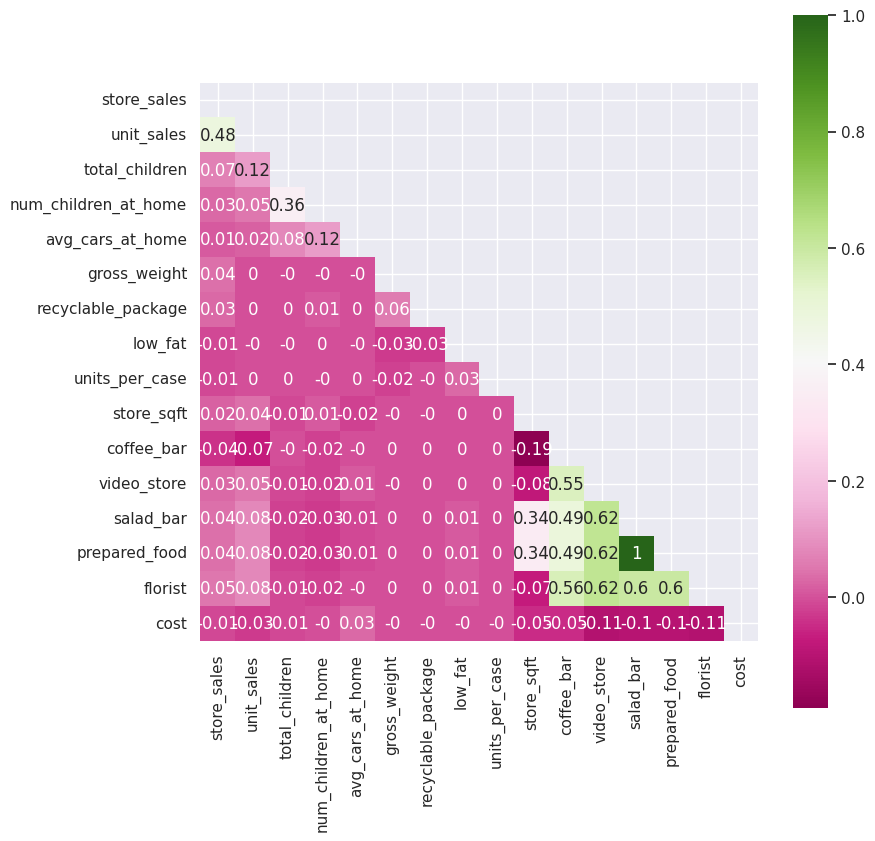

In [18]:
# Compute the correlation matrix
corr = training_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up mpl figure
fig, axes = plt.subplots(figsize=(9,9))

# Make the corrplot
sns.heatmap(corr.round(2), mask=mask, cmap="PiYG", annot=True, square=True)

Here we learn that we can just use salad bar or prepared food, not both.

# Determine Feature Importance
Use cross-validation and lgboost to determine the importance of all the features.

In [19]:
# The grading metric is rmsle, so log convert the cost make things easy.
training_df['log_cost'] = np.log1p(training_df['cost'])
target = 'log_cost'

training_df

,store_sales,unit_sales,total_children,num_children_at_home,avg_cars_at_home,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,log_cost
id,,,,,,,,,,,,,,,,,
0,8.61,3,2,2,2,10.30,1,0,32,36509,0,0,0,0,0,62.09,4.144562
1,5.00,2,4,0,3,6.66,1,0,1,28206,1,0,0,0,0,121.80,4.810557
2,14.08,4,0,0,3,21.30,1,0,26,21215,1,0,0,0,0,83.51,4.436870
3,4.02,3,5,0,0,14.80,0,1,36,21215,1,0,0,0,0,66.78,4.216267
4,2.13,3,5,0,3,17.00,1,1,20,27694,1,1,1,1,1,111.51,4.723042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651918,3.70,2,4,4,1,10.40,1,1,18,34452,1,0,0,0,1,147.17,4.998360
651919,10.36,4,2,0,2,9.43,0,0,20,30797,1,1,1,1,1,92.57,4.538710
651920,11.19,3,3,0,3,18.50,0,0,5,30797,1,1,1,1,1,92.57,4.538710


In [20]:
# Create some LightGBM trees to determine which features are important.
# https://github.com/aerdem4/lofo-importance#readme

kfold_importance = KFold(n_splits=5, shuffle=True, random_state=29)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

dataset = Dataset(
    df=training_df.sample(frac=0.5, random_state=29),
    target=target,
    features=all_features
)

lgbm = LGBMRegressor(random_state=29)

lofo_importance = LOFOImportance(
    dataset=dataset,
    cv=kfold_importance,
    scoring=scorer,
    model=lgbm
)

  0%|          | 0/15 [00:00<?, ?it/s]

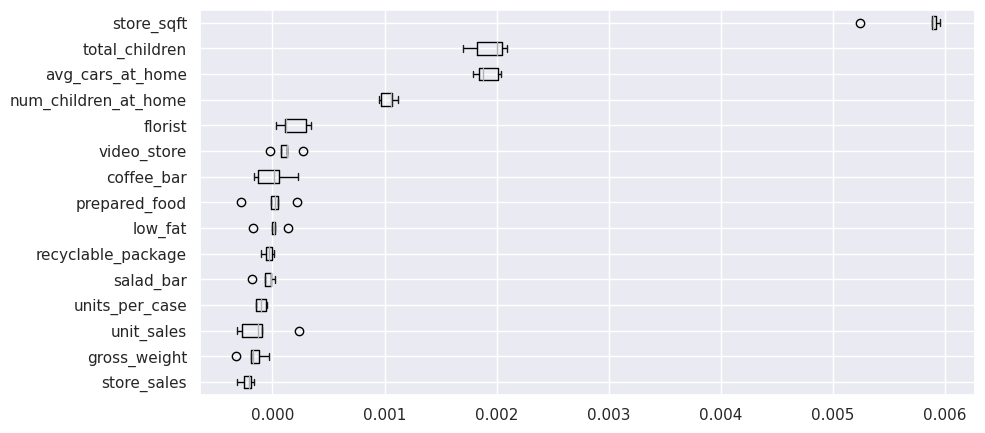

In [21]:
plot_importance(
    lofo_importance.get_importance(),
    figsize=(10,5),
    kind='box'
)

In [22]:
# Based on the feature importance plot, the following features matter
important_features = [
    'store_sqft',
    'avg_cars_at_home',
    'total_children',
    'num_children_at_home',
    'florist',
    'salad_bar',
    'video_store',
    'coffee_bar'
]

# Group Duplicates

Base on the notebooks I read, I wanted to explore duplicates.
Most of the important features are unique categories, so group them together.

In [23]:
training_grouped = training_df.groupby(important_features).log_cost.\
    agg(['mean', 'std', 'count']).sort_values('count')

print(f'There are {len(training_grouped)} groups.')

training_grouped.tail(10)

There are 3064 groups.


mean  \
store_sqft avg_cars_at_home total_children num_children_at_home florist salad_bar video_store coffee_bar             
27694      2                4              0                    1       1         1           1           4.463926   
30268      1                1              0                    0       0         0           0           4.513277   
33858      2                3              0                    1       1         0           1           4.545807   
27694      3                4              0                    1       1         1           1           4.413870   
21215      2                1              0                    0       0         0           1           4.591814   
           1                1              0                    0       0         0           1           4.556367   
20319      2                1              0                    0       0         0           0           4.513022   
27694      2                1              0                    1       1         1           1           4.320717   
30797      2                1              0                    1       1         1           1           4.518016   
33858      1                1              0                    1       1         0           1           4.526016   

                                                                                                               std  \
store_sqft avg_cars_at_home total_children num_children_at_home florist salad_bar video_store coffee_bar             
27694      2                4              0                    1       1         1           1           0.367997   
30268      1                1              0                    0       0         0           0           0.278614   
33858      2                3              0                    1       1         0           1           0.323612   
27694      3                4              0                    1       1         1           1           0.341281   
21215      2                1              0                    0       0         0           1           0.301488   
           1                1              0                    0       0         0           1           0.264321   
20319      2                1              0                    0       0         0           0           0.403705   
27694      2                1              0                    1       1         1           1           0.287672   
30797      2                1              0                    1       1         1           1           0.225328   
33858      1                1              0                    1       1         0           1           0.328613   

                                                                                                          count  
store_sqft avg_cars_at_home total_children num_children_at_home florist salad_bar video_store coffee_bar         
27694      2                4              0                    1       1         1           1            1616  
30268      1                1              0                    0       0         0           0            1660  
33858      2                3              0                    1       1         0           1            1662  
27694      3                4              0                    1       1         1           1            1708  
21215      2                1              0                    0       0         0           1            1773  
           1                1              0                    0       0         0           1            1820  
20319      2                1              0                    0       0         0           0            1868  
27694      2                1              0                    1       1         1           1            1882  
30797      2                1              0                    1       1         1           1            1943  
33858      1          

For models that have a sample_weight parameter in the fit() function, one can
save time by grouping together these features. But I chose not to do that.

# View Store Square Feet as a Category
There really aren't too many options for store_sqft. It acts more like
a category. The partial dependence plot shows there isn't really a trend
as the store area changes.

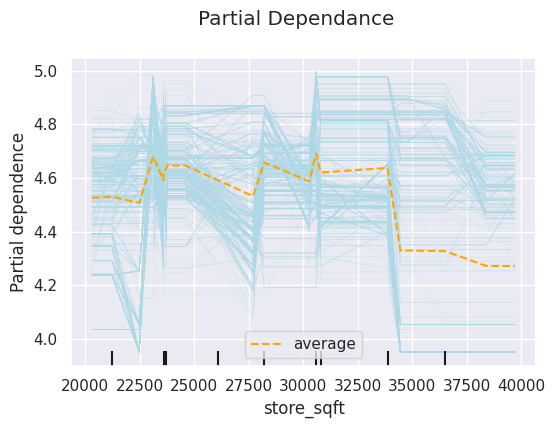

In [24]:
model = RandomForestRegressor(
    bootstrap=False,
    n_estimators=100,
    min_weight_fraction_leaf=5/411699,
    random_state=29
)

model.fit(training_df[important_features], training_df['log_cost'])

plt.figure(figsize=(6, 4))
plt.suptitle('Partial Dependance', y=1.0)
PartialDependenceDisplay.from_estimator(
    model,
    training_df[important_features].sample(500),
    ['store_sqft'],
    percentiles=(0,1),
    pd_line_kw={'color':'orange'},
    ice_lines_kw={'color': 'lightblue'},
    kind='both',
    ax=plt.gca()
)

# Ensemble Model Functions
Create a list to hold all the models, and create a function that performs
K-Fold validation.

In [25]:
result_list = []

In [26]:
# KFold CV Model
def kfold_scorer(model, df, features, target, folds=5, label=None):
    #Cross-Validate the given model, dataframe, and features within it
    score_list = []
    oof = np.zeros_like(df[target], dtype=float)
    kf = KFold(n_splits=folds, shuffle=True)

    for fold, (idx_tr, idx_va) in enumerate(kf.split(df)):
        X_tr = df.iloc[idx_tr][features]
        y_tr = df.iloc[idx_tr][target]
        X_va = df.iloc[idx_va][features]
        y_va = df.iloc[idx_va][target]

        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va)

        rmse_va = mean_squared_error(y_va, y_va_pred, squared=False)
        print(f"Fold {fold}: rmse = {rmse_va:.4f}")

        oof[idx_va] = y_va_pred
        score_list.append(rmse_va)

    rmse = sum(score_list) / len(score_list)
    print(f"Average RMSE: {rmse:0.4f} {label if label is not None else ''}")

    if label is not None:
        global result_list
        result_list.append((label, model, features, rmse, oof))

# Model - Ridge Regression

In [27]:
# One-hot encode the features and use a polynomial transformer 3

# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_
#   mixed_types.html#column-transformer-with-mixed-types
# https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features
# https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression

ridge_model = make_pipeline(
    ColumnTransformer([('ohe', OneHotEncoder(drop='first'),
                        ['total_children', 'num_children_at_home',
                         'avg_cars_at_home', 'store_sqft'])],
                      remainder='passthrough'),
    PolynomialFeatures(3, interaction_only=True, include_bias=False),
    Ridge()
)

kfold_scorer(ridge_model, training_df, important_features, target,
             label='Ridge Regression')

Fold 0: rmse = 0.2943
Fold 1: rmse = 0.2955
Fold 2: rmse = 0.2946
Fold 3: rmse = 0.2942
Fold 4: rmse = 0.2947
Average RMSE: 0.2946 Ridge Regression


# Model - Random Forest

In [28]:
# Target encoded random forest

# https://contrib.scikit-learn.org/category_encoders/targetencoder.html
# https://scikit-learn.org/stable/modules/ensemble.html#random-forests

rf_model = make_pipeline(
    TargetEncoder(verbose=30, cols=['store_sqft'], handle_unknown='error'),
    RandomForestRegressor(
        bootstrap=True,
        oob_score=True,

        n_estimators=500,
        max_features=5,
        min_samples_leaf=4,

        n_jobs=-1,
        random_state=29
    )
)

kfold_scorer(rf_model, training_df, important_features, target,
             label='Random Forest')

Fold 0: rmse = 0.2940
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2934
Fold 3: rmse = 0.2924
Fold 4: rmse = 0.2951
Average RMSE: 0.2936 Random Forest


# Model - Extra Trees Regressor

In [29]:
# Use all the features

# https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

et_model = ExtraTreesRegressor(
    bootstrap=True,
    oob_score=True,

    n_estimators=500,
    max_features=8,
    min_samples_leaf=1,

    n_jobs=-1,
    random_state=29
)

kfold_scorer(et_model, training_df, important_features, target,
             label='Extra Trees')

Fold 0: rmse = 0.2939
Fold 1: rmse = 0.2931
Fold 2: rmse = 0.2938
Fold 3: rmse = 0.2934
Fold 4: rmse = 0.2939
Average RMSE: 0.2936 Extra Trees


# Model - Histogram-Based Gradient Boosting Regressor

In [30]:
# Histogram-Based Gradient Boosting Regressor

# https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

histgrad_model = HistGradientBoostingRegressor(
    max_iter=320,
    max_leaf_nodes=128,
    min_samples_leaf=2
)

kfold_scorer(histgrad_model, training_df, important_features, target,
             label='HGB')

Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2942
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2946
Fold 4: rmse = 0.2930
Average RMSE: 0.2936 HGB


# Model - CatBoost, LightGBM, and XGBoost

## XGBoost

In [31]:
# https://xgboost.readthedocs.io/en/stable/parameter.html

xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 3,

    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'enable_categorical': True,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'tree_method': 'gpu_hist',
    'n_jobs': -1,

    'verbosity': 1,
    'random_state': 29
}

In [32]:
xgb_model = xgboost.XGBRegressor(**xgb_params)

kfold_scorer(xgb_model, training_df, important_features, target,
             label='XGBoost')

Fold 0: rmse = 0.2939
Fold 1: rmse = 0.2936
Fold 2: rmse = 0.2933
Fold 3: rmse = 0.2936
Fold 4: rmse = 0.2937
Average RMSE: 0.2936 XGBoost


## LightGBM

In [36]:
# https://lightgbm.readthedocs.io/en/v3.3.2/Parameters.html

lgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_leaves': 100,

    'min_child_samples': 1,
    'min_child_weight': 1e1,

    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',

    #'device': 'gpu',
    'random_state': 29
}

In [37]:
lgb_model = lightgbm.LGBMRegressor(**lgb_params)

kfold_scorer(lgb_model, training_df, important_features, target,
             label='LightGBM')

Fold 0: rmse = 0.2935
Fold 1: rmse = 0.2938
Fold 2: rmse = 0.2932
Fold 3: rmse = 0.2936
Fold 4: rmse = 0.2939
Average RMSE: 0.2936 LightGBM


## CatBoost

In [38]:
# https://catboost.ai/en/docs/references/training-parameters/

cb_params = {
    'n_estimators' : 2000,
    'eta': 0.05,
    'max_depth': 8,

    'verbose': False,
    'boost_from_average': True
}

In [39]:
cb_model = catboost.CatBoostRegressor(**cb_params)

kfold_scorer(cb_model, training_df, important_features, target,
             label='CatBoost')

Fold 0: rmse = 0.2941
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2939
Fold 3: rmse = 0.2938
Fold 4: rmse = 0.2942
Average RMSE: 0.2938 CatBoost


# Final Evaluation

In [40]:
result_list

[('Ridge Regression',
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('ohe',
                                                    OneHotEncoder(drop='first'),
                                                    ['total_children',
                                                     'num_children_at_home',
                                                     'avg_cars_at_home',
                                                     'store_sqft'])])),
                  ('polynomialfeatures',
                   PolynomialFeatures(degree=3, include_bias=False,
                                      interaction_only=True)),
                  ('ridge', Ridge())]),
  ['store_sqft',
   'avg_cars_at_home',
   'total_children',
   'num_children_at_home',
   'florist',
   'salad_bar',
   'video_store',
   'coffee_bar'],
  0.2946452837225307,
  array([4.52767447, 4.67982079, 4.629631  , ..., 4.430

In [41]:
# DataFrame of all results, sorted by score
result_df = pd.DataFrame(
    result_list,
    columns=['label', 'model', 'features', 'rmse', 'oof']
)
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df = result_df[~result_df.label.str.contains('mean')]
result_df.sort_values('rmse', inplace=True)
result_df.reset_index(drop=True, inplace=True)

result_df

,label,model,features,rmse,oof
0,XGBoost,"XGBRegressor(base_score=None, booster=None, ca...","[store_sqft, avg_cars_at_home, total_children,...",0.293610,"[4.594296932220459, 4.687042236328125, 4.63861..."
1,LightGBM,"LGBMRegressor(learning_rate=0.05, max_depth=8,...","[store_sqft, avg_cars_at_home, total_children,...",0.293618,"[4.635041846339968, 4.687860823630805, 4.63520..."
2,Extra Trees,"(ExtraTreeRegressor(max_features=8, random_sta...","[store_sqft, avg_cars_at_home, total_children,...",0.293637,"[4.638269934164593, 4.693190614566251, 4.64347..."
3,Random Forest,"(TargetEncoder(cols=['store_sqft'], handle_unk...","[store_sqft, avg_cars_at_home, total_children,...",0.293640,"[4.643737350942243, 4.681457240169312, 4.63075..."
4,HGB,"HistGradientBoostingRegressor(max_iter=320, ma...","[store_sqft, avg_cars_at_home, total_children,...",0.293643,"[4.645278999424511, 4.678072887529773, 4.63786..."
5,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,"[store_sqft, avg_cars_at_home, total_children,...",0.293848,"[4.643256350897387, 4.672201033313647, 4.62562..."
6,Ridge Regression,"(ColumnTransformer(remainder='passthrough',\n ...","[store_sqft, avg_cars_at_home, total_children,...",0.294645,"[4.527674472665034, 4.67982079297115, 4.629630..."


# Use Ridge Regression to Determine Weights for Each Model

In [42]:
# Make a DataFrame of the out-of-fold results and their model for
# Model weighting
oof_results_df = pd.DataFrame()
for i in range(len(result_df)):
    oof_results_df[result_df.loc[i]['label']] = pd.Series(result_df.loc[i]['oof'])

oof_results_df.head(5)

,XGBoost,LightGBM,Extra Trees,Random Forest,HGB,CatBoost,Ridge Regression
0,4.594297,4.635042,4.638270,4.643737,4.645279,4.643256,4.527674
1,4.687042,4.687861,4.693191,4.681457,4.678073,4.672201,4.679821
2,4.638613,4.635206,4.643472,4.630754,4.637865,4.625625,4.629631
3,4.686651,4.683649,4.708396,4.695214,4.686800,4.686869,4.709817
4,4.491332,4.499430,4.510097,4.473456,4.516114,4.491466,4.473708


In [43]:
optimum_blend = Ridge(positive=True, tol=1e-6, alpha=100)
optimum_blend.fit(oof_results_df, training_df.log_cost.values)
optimum_oof = optimum_blend.predict(oof_results_df)

trmse = mean_squared_error(training_df.log_cost.values, optimum_oof,
                           squared=False)

print(f'Ridge regression blend rmse: {trmse:0.5f}')

display(pd.Series(optimum_blend.coef_.round(4), oof_results_df.columns,
                  name='weight'))

result_list.append(('Optimum Blend', None, None, trmse, optimum_oof))

Ridge regression blend rmse: 0.29343


XGBoost             0.1784
LightGBM            0.1471
Extra Trees         0.1834
Random Forest       0.1757
HGB                 0.1583
CatBoost            0.0891
Ridge Regression    0.0656
Name: weight, dtype: float64

In [44]:
result_list[-1]

('Optimum Blend',
 None,
 None,
 0.2934348473324858,
 array([4.62500981, 4.68376502, 4.63555167, ..., 4.43520995, 4.56487069,
        4.65484028]))

# Submission
Each model in the results list make predictions on the testing set
Blend the results using the optimum blend weights
Transform log_cost to actual cost
Submit results

In [45]:
test_preds_df = pd.DataFrame(index=test_df.index)
for i in range(len(result_list)-1):
    test_model = result_list[i][1]
    test_preds_df[result_list[i][0]] = test_model.predict(test_df[important_features])

test_preds_df

,Ridge Regression,Random Forest,Extra Trees,HGB,XGBoost,LightGBM,CatBoost
id,,,,,,,
360336,4.515555,4.520553,4.514577,4.517511,4.520125,4.511439,4.522416
360337,4.551703,4.560241,4.550098,4.544738,4.563454,4.557725,4.553831
360338,4.555954,4.553500,4.562270,4.558799,4.559219,4.547991,4.563135
360339,4.611623,4.585465,4.608110,4.617965,4.608824,4.626146,4.590729
360340,4.379516,4.375397,4.366535,4.370114,4.365315,4.371854,4.376062
...,...,...,...,...,...,...,...
600555,4.618960,4.621560,4.620699,4.632843,4.629403,4.634539,4.626786
600556,4.521982,4.511427,4.515022,4.519632,4.512599,4.515271,4.511193
600557,4.555954,4.553500,4.562270,4.558799,4.559219,4.547991,4.563135


In [48]:
test_preds_df['blend'] = optimum_blend.predict(test_preds_df[[
    'XGBoost',
    'LightGBM',
    'Extra Trees',
    'Random Forest',
    'HGB',
    'CatBoost',
    'Ridge Regression'
]])

In [49]:
test_preds_df

,Ridge Regression,Random Forest,Extra Trees,HGB,XGBoost,LightGBM,CatBoost,blend
id,,,,,,,,
360336,4.515555,4.520553,4.514577,4.517511,4.520125,4.511439,4.522416,4.517490
360337,4.551703,4.560241,4.550098,4.544738,4.563454,4.557725,4.553831,4.554993
360338,4.555954,4.553500,4.562270,4.558799,4.559219,4.547991,4.563135,4.557185
360339,4.611623,4.585465,4.608110,4.617965,4.608824,4.626146,4.590729,4.607025
360340,4.379516,4.375397,4.366535,4.370114,4.365315,4.371854,4.376062,4.371407
...,...,...,...,...,...,...,...,...
600555,4.618960,4.621560,4.620699,4.632843,4.629403,4.634539,4.626786,4.626629
600556,4.521982,4.511427,4.515022,4.519632,4.512599,4.515271,4.511193,4.514947
600557,4.555954,4.553500,4.562270,4.558799,4.559219,4.547991,4.563135,4.557185


In [51]:
submission = pd.DataFrame()

In [52]:
submission['cost'] = np.expm1(test_preds_df['blend'])
submission.to_csv('submission8.csv', index='id')
submission

,cost
id,
360336,90.605403
360337,94.106074
360338,94.314806
360339,99.185633
360340,78.154907
...,...
600555,101.169030
600556,90.372726
600557,94.314806
